In [ ]:
import intake
import xarray as xr
import xshelftransects
import numpy as np

url_google = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"

catalog = intake.open_esm_datastore(url_google)
search_result = catalog.search(source_id = "ACCESS-ESM1-5",
                               experiment_id=['historical'], 
                               variable_id=['deptho', "thetao"]).search(member_id = ['r1i1p1f1'])

ds_dict = search_result.to_dataset_dict(zarr_kwargs={'consolidated': True})

ds = xr.merge([ds_dict['CMIP.CSIRO.ACCESS-ESM1-5.historical.Ofx.gn'], ds_dict['CMIP.CSIRO.ACCESS-ESM1-5.historical.Omon.gn']])
ds = ds[["deptho", "thetao"]].isel(member_id = 0, dcpp_init_year = 0, time = slice(0, 24))


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


<div><progress max="2" value="2"></progress> 100.00% [2/2 00:00&lt;00:00]</div>

/var/folders/vt/sjvxnnwn7y51hx1c814wrxn80000gn/T/ipykernel_5426/2871569386.py:15: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds = xr.merge([ds_dict['CMIP.CSIRO.ACCESS-ESM1-5.historical.Ofx.gn'], ds_dict['CMIP.CSIRO.ACCESS-ESM1-5.historical.Omon.gn']])
/var/folders/vt/sjvxnnwn7y51hx1c814wrxn80000gn/T/ipykernel_5426/2871569386.py:15: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kw

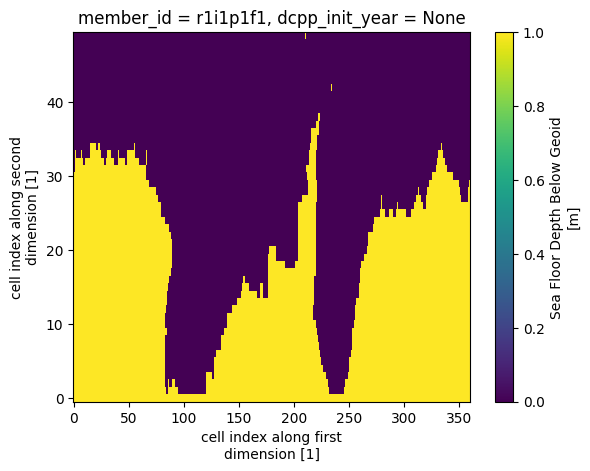

In [31]:
ds_so = ds.isel(j = slice(0, 50)) #just get the southern ocean 
ds_so = ds_so.rename({"latitude":"lat", "longitude":"lon", "lev":"z_l"}) #rename dimenstions

boundary_mask = (ds_so.deptho.fillna(0.0) <= 0.0).compute()
boundary_mask.plot()

In [42]:

transects, geometry = xshelftransects.cross_shelf_transects(
    ds_so,
    "thetao",                    # str | list[str]
    boundary_mask,          # DataArray; contour(level=0.5) defines transect_length=0
    transect_length=np.arange(0.0, 5 * 100e3 + 2e3, 2e3),
    transect_spacing=50e3,
    crs="EPSG:3031",
    engine="xesmf",
    method="bilinear",
    reuse_weights=False,
    regridder=None,
    lon_name="lon",
    lat_name="lat",
    return_geometry=True,
)

/Users/anthonymeza/miniforge3/envs/xshelftransects/lib/python3.11/site-packages/xarray/core/nputils.py:256: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/Users/anthonymeza/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/Documents/GitHub/xshelftransects/src/xshelftransects/sampling.py:160: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'loc' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  return vloc_ds.assign_coords(loc=mi).unstack("loc").assi

In [43]:
transects
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


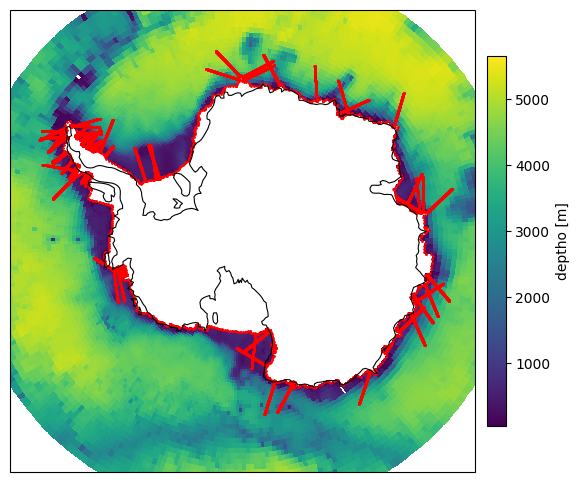

In [ ]:
# # Plot geometry
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -60], crs=ccrs.PlateCarree())
ax.coastlines(resolution="110m", linewidth=0.8)
#
m = ax.pcolormesh(ds_so["lon"], ds_so["lat"], ds_so["deptho"], transform=ccrs.PlateCarree(), shading="auto")
fig.colorbar(m, ax=ax, shrink=0.8, pad=0.02, label="deptho [m]")
#
ax.scatter(geometry["contour_lon"], geometry["contour_lat"], transform=ccrs.PlateCarree(), s=1, color="red")
#
for i in range(0, geometry.sizes["section"]):
    ax.scatter(geometry["lon"].isel(section=i), geometry["lat"].isel(section=i),
            transform=ccrs.PlateCarree(), s=1, color="red", alpha=0.8)

plt.savefig()